# Main project file

this notebook contains the main figures of the report, tested on the LPW dataset, it shows and computes the different image transformations. It also contains the circle and blob detection algorithms. Finally it shows the different metrics analysing the accrucay of the segmentation of the eye and the cooridnates of the pupils compared to the ground truth.

In [2]:
import numpy as np
from skimage.color import rgb2gray
import cv2
import os
import pandas as pd

from tqdm import tqdm

from matplotlib import pyplot as plt
from matplotlib.image import imread
from matplotlib.patches import Circle
%matplotlib inline

from scipy.ndimage import gaussian_filter
from scipy.ndimage import convolve
from skimage.transform import resize
from skimage.morphology import *
from skimage.feature import blob_doh
from skimage.transform import hough_circle
from skimage.feature import canny

In [3]:
#functions used in edge canny from scratch

def gaussian_smoothing(img):
    smoothed_img = gaussian_filter(img, sigma=5)
    return smoothed_img

def gradient(img):
    sobel_x = np.array([[-1, 0, 1],
                        [-2, 0, 2],
                        [-1, 0, 1]])
    sobel_y = np.array([[1, 2, 1],
                        [0, 0, 0],
                        [-1, -1, -2]])
    sobel_x_img = convolve(img, sobel_x, mode='constant')
    sobel_y_img = convolve(img, sobel_y, mode='constant')
    g_magnitude = np.sqrt(sobel_x_img ** 2 + sobel_y_img ** 2)
    g_dir = np.arctan2(sobel_x_img, sobel_y_img)
    return g_magnitude, g_dir

def non_maximum_suppression(g_magnitude, g_dir):
    g_dir[g_dir < 0] += np.pi
    g_dir_hat = np.floor_divide(g_dir, np.pi / 4)
    g_max = np.zeros_like(g_magnitude)
    for x in range(1, g_magnitude.shape[0] - 1):
        for y in range(1, g_magnitude.shape[1] - 1):
            magnitude = g_magnitude[x, y]
            dir_hat = g_dir_hat[x, y]
            if dir_hat == 0:  # east/west
                if np.greater_equal(magnitude, g_magnitude[x, y-1]) and np.greater_equal(magnitude, g_magnitude[x, y+1]):
                    g_max[x, y] = magnitude
            elif dir_hat == 1: #northeast/southwest
                if np.greater_equal(magnitude, g_magnitude[x+1, y-1]) and np.greater_equal(magnitude, g_magnitude[x-1, y+1]):
                    g_max[x, y] = magnitude
            elif dir_hat == 2: #nort/south
                if np.greater_equal(magnitude, g_magnitude[x+1, y]) and np.greater_equal(magnitude, g_magnitude[x-1, y]):
                    g_max[x, y] = magnitude
            elif dir_hat == 3: #nortwest/southeast
                if np.greater_equal(magnitude, g_magnitude[x+1, y+1]) and np.greater_equal(magnitude, g_magnitude[x-1, y-1]):
                    g_max[x, y] = magnitude
    return g_max

def double_thresholding(g_max, thresh_lo, thresh_hi):
    thresh_img = np.zeros_like(g_max)
    for x in range(g_max.shape[0]):
      for y in range(g_max.shape[1]):
          mag = g_max[x, y]   
          if mag > thresh_hi:
              thresh_img[x, y] = 255 #strong
          elif mag > thresh_lo:
              thresh_img[x, y] = 128 #weak
    return thresh_img

def connectivity(thresh_img):
    edge_img = np.zeros_like(thresh_img)
    for x in range(thresh_img.shape[0]):
      for y in range(thresh_img.shape[1]):
        edge = thresh_img[x,y]
        if edge == 255:
          edge_img[x,y] = edge
        if edge == 128:
          if thresh_img[x-1,y-1]==255 or thresh_img[x-1,y]==255 or thresh_img[x,y-1]==255 or thresh_img[x+1,y]==255 or thresh_img[x+1,y+1]==255:
            edge_img[x,y] = edge
    return edge_img

In [4]:
# edge canny from scratch

def canny_edge_detector(img, thresh_lo=0.01, thresh_hi=0.04):
    """
    The Canny edge detector.
    
    Inputs:
        img              The input image
        thresh_lo        The fraction of the maximum gradient magnitude which will 
                         be considered the lo threshold. 
        thresh_hi        The fraction of the maximum gradient magnitude which will
                         be considered the hi threshold. Ideally should be 2x to 3x 
                         thresh_lo.
                         
    Outputs: 
        edge_img         A binary image, with pixels lying on edges marked with a 1, 
                         and others with a 0.
    """
    
    # Smooth the image first. 
    smoothed             = gaussian_smoothing(img)
    
    # Find gradient magnitude and direction
    g_magnitude, g_dir   = gradient(smoothed)
    
    # Non-maximum suppression
    g_max                = non_maximum_suppression(g_magnitude, g_dir)
    
    # Double thresholding
    thresh_img           = double_thresholding(g_max, thresh_lo, thresh_hi)
    
    # Final edge connectivity
    edge_img             = connectivity(thresh_img)
    
    # Return the result
    return edge_img

In [5]:
# detect circles fromm scratch

def detectCircles(img,threshold,region,radius): 
    (M,N) = img.shape
    [R_max,R_min] = radius
    R = R_max - R_min
    #Initializing accumulator array.
    #Accumulator array is a 3 dimensional array with the dimensions representing
    #the radius, X coordinate and Y coordinate resectively.
    #Also appending a padding of 2 times R_max to overcome the problems of overflow
    A = np.zeros((R_max,M+2*R_max,N+2*R_max))
    B = np.zeros((R_max,M+2*R_max,N+2*R_max))

    #Precomputing all angles to increase the speed of the algorithm
    theta = np.arange(0,360)*np.pi/180
    edges = np.argwhere(img[:,:])                                               #Extracting all edge coordinates
    for val in range(R):
        r = R_min+val
        #Creating a Circle Blueprint
        bprint = np.zeros((2*(r+1),2*(r+1)))
        (m,n) = (r+1,r+1)                                                       #Finding out the center of the blueprint
        for angle in theta:
            x = int(np.round(r*np.cos(angle)))
            y = int(np.round(r*np.sin(angle)))
            bprint[m+x,n+y] = 1
        constant = np.argwhere(bprint).shape[0]
        for x,y in edges:                                                       #For each edge coordinates
            #Centering the blueprint circle over the edges
            #and updating the accumulator array
            X = [x-m+R_max,x+m+R_max]                                           #Computing the extreme X values
            Y= [y-n+R_max,y+n+R_max]                                            #Computing the extreme Y values
            A[r,X[0]:X[1],Y[0]:Y[1]] += bprint
        A[r][A[r]<threshold*constant/r] = 0

    for r,x,y in np.argwhere(A):
        temp = A[r-region:r+region,x-region:x+region,y-region:y+region]
        try:
            p,a,b = np.unravel_index(np.argmax(temp),temp.shape)
        except:
            continue
        B[r+(p-region),x+(a-region),y+(b-region)] = 1

    return B[:,R_max:-R_max,R_max:-R_max]



In [6]:
def displayCircles(image, coor):
    fig = plt.figure()
    plt.imshow(image)
    circleCoordinates = np.argwhere(coor)                                          #Extracting the circle information
    circle = []
    for r,x,y in circleCoordinates:
        circle.append(plt.Circle((y,x),r,color=(1,0,0),fill=False))
        fig.add_subplot(111).add_artist(circle[-1])
    plt.show()


In [7]:
def mask_image(gray, threshold):
    mask = gray > threshold
    return mask

In [8]:
def dilated_image(image, rep):
  dilated = dilation(image)
  for i in range(rep-1):
    dilated=dilation(dilated)
  return dilated

In [9]:
def NewdisplayCircles(image, coor, filename):
    h = image.shape[0]
    w = image.shape[1]
    # Create a figure and axis
    fig, ax = plt.subplots()
    # Read in an image and display it on the axis
    ax.imshow(image)
    # Create a circle patch with the desired coordinates and radius
    circleCoordinates = np.argwhere(coor)
    circleCoordinates = np.mean(circleCoordinates, axis=0)
    if len(circleCoordinates)==0:
        circleCoordinates=[[30,h/2,w/2]]
    r,y,x = circleCoordinates
    circle = Circle((x,y), r, color='red', fill=False)
    # Add the circle patch to the axis
    ax.add_patch(circle)
    # Save the figure
    plt.savefig(filename)
    # close the figure
    plt.close(fig)
    # read the saved file and return the image
    return plt.imread(filename)

In [10]:
def output_coor_circles(image, coor):
    circleCoordinates = np.argwhere(coor)
    circleCoordinates = np.mean(circleCoordinates, axis=0)
    return circleCoordinates 

In [11]:
def displayBlob(image, blob, filename):
    h = image.shape[0]
    w = image.shape[1]
    # Create a figure and axis
    fig, ax = plt.subplots()
    # Read in an image and display it on the axis
    ax.imshow(image)
    if len(blob)==0:
        blob=[[h/2,w/2,30]]
    blob = np.mean(blob, axis=0)
    y, x, r = blob
    c = plt.Circle((x, y), r, color='red', linewidth=2, fill=False)
    ax.add_patch(c)
    # Save the figure
    plt.savefig(filename)
    # close the figure
    plt.close(fig)
    # read the saved file and return the image
    return plt.imread(filename)

In [12]:
def output_coor_blob(image, blob):
    h = image.shape[0]
    w = image.shape[1]
    if len(blob)==0:
        blob=[[h/2,w/2,30]]
    blob = np.mean(blob, axis=0)
    return blob

In [13]:
def output_coor_blob_safe(image, blob, coor_circles):
    h = image.shape[0]
    w = image.shape[1]
    if len(blob)==0:
        blob=[[coor_circles[1],coor_circles[2],coor_circles[0]]]
    blob = np.mean(blob, axis=0)
    return blob

In [14]:
image_path = '1_000/'
files = os.listdir(image_path)
num_files = len(files)

In [15]:

column_names = ["x", "y"]
df = pd.read_csv("1.txt",names=column_names, sep=" ")
df = df[['y','x']]
print(df.head())
print(df.shape)

       y      x
0  305.0  334.0
1  304.6  333.8
2  304.2  333.6
3  303.8  333.4
4  303.4  333.2
(2000, 2)


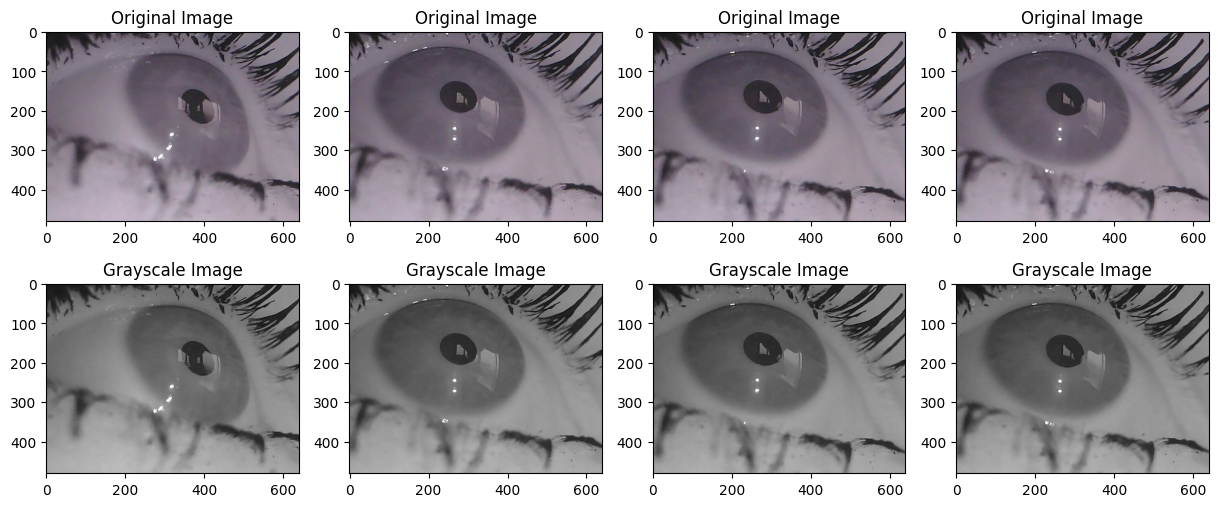

In [23]:
images_to_read=['1_001','1_060','1_150','1_210']
image_path = '2_000/'

image = []
gray = []

fig, axes = plt.subplots(figsize=(15, 6), ncols=4, nrows=2)
for i in range(4):
    image.append(imread(image_path+images_to_read[i]+'.jpg'))
    gray.append(rgb2gray(image[i]))

    axes[0][i].imshow(image[i])
    axes[0][i].set_title("Original Image")
    axes[1][i].imshow(gray[i], cmap='gray')
    axes[1][i].set_title("Grayscale Image")


100%|██████████| 4/4 [00:32<00:00,  8.17s/it]


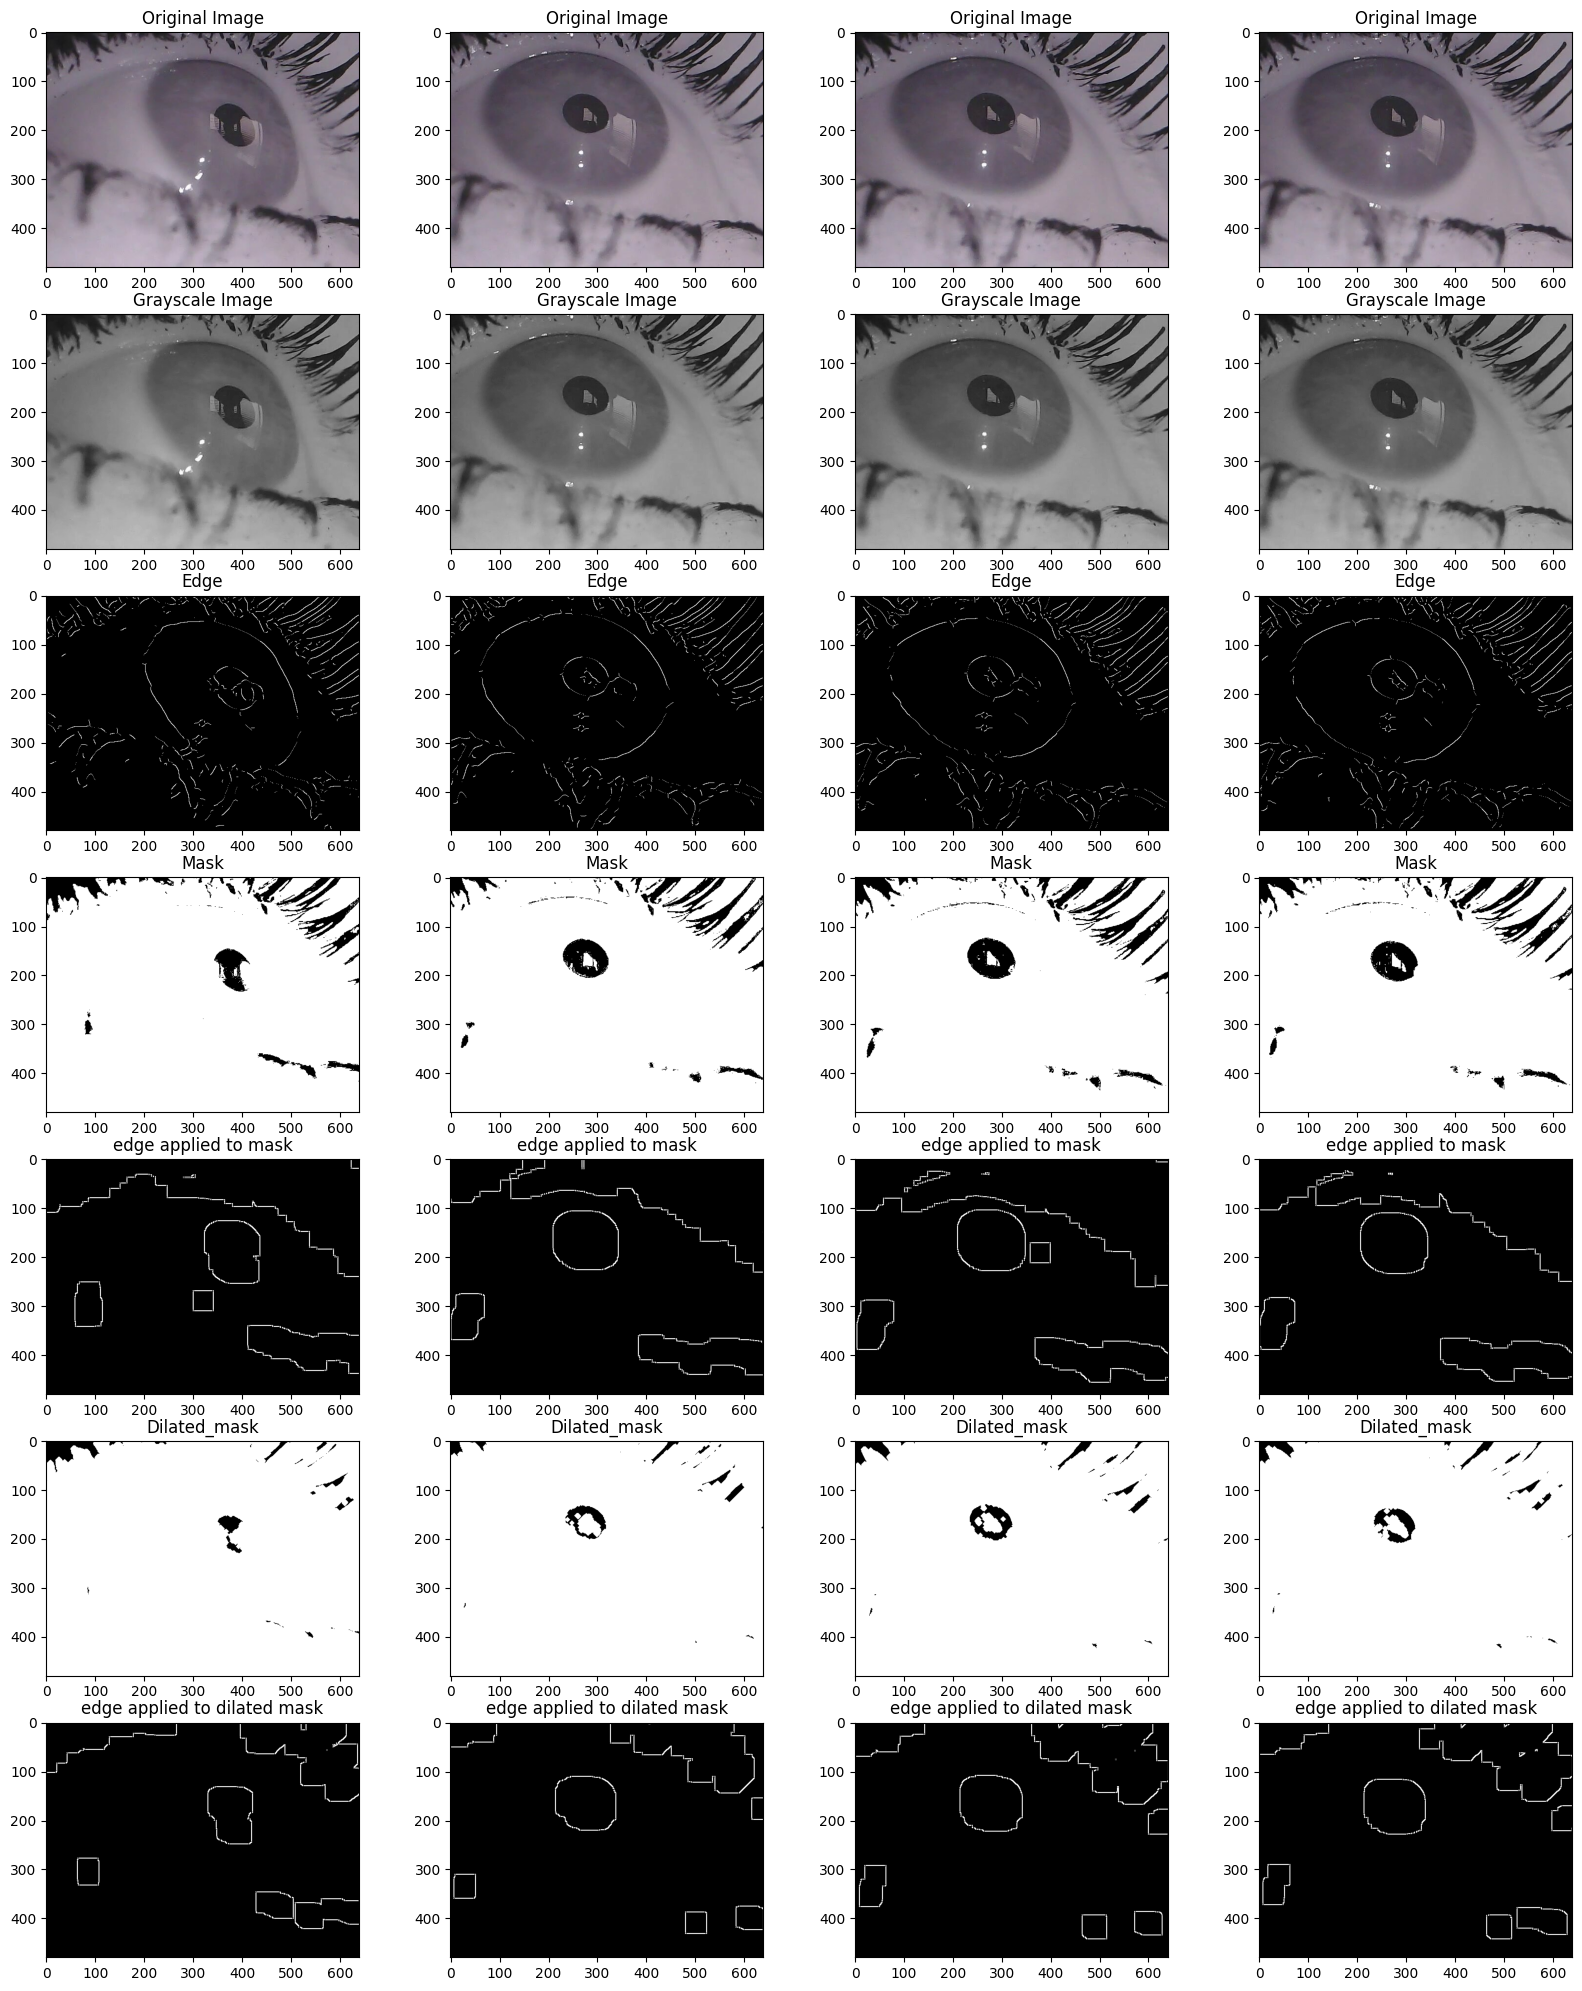

In [24]:

edge = []
mask = []
mask_edge = []
dilated_mask = []
dilated_mask_edge = []

fig, axes = plt.subplots(figsize=(20, 25), ncols=4, nrows=7)
for i in tqdm(range(4)):
    edge.append(canny_edge_detector(gray[i]))
    mask.append(mask_image(gray[i],0.2))
    mask_edge.append(canny_edge_detector(mask[i]).astype(np.uint8))
    dilated_mask.append(dilated_image(mask[i], 5))
    dilated_mask_edge.append(canny_edge_detector(dilated_mask[i]).astype(np.uint8))

    axes[0][i].imshow(image[i])
    axes[0][i].set_title("Original Image")
    axes[1][i].imshow(gray[i], cmap='gray')
    axes[1][i].set_title("Grayscale Image")
    axes[2][i].imshow(edge[i], cmap='gray')
    axes[2][i].set_title("Edge")
    axes[3][i].imshow(mask[i], cmap='gray')
    axes[3][i].set_title("Mask")
    axes[4][i].imshow(mask_edge[i], cmap='gray')
    axes[4][i].set_title("edge applied to mask")
    axes[5][i].imshow(dilated_mask[i], cmap='gray')
    axes[5][i].set_title("Dilated_mask")
    axes[6][i].imshow(dilated_mask_edge[i], cmap='gray')
    axes[6][i].set_title("edge applied to dilated mask")

100%|██████████| 4/4 [01:40<00:00, 25.01s/it]


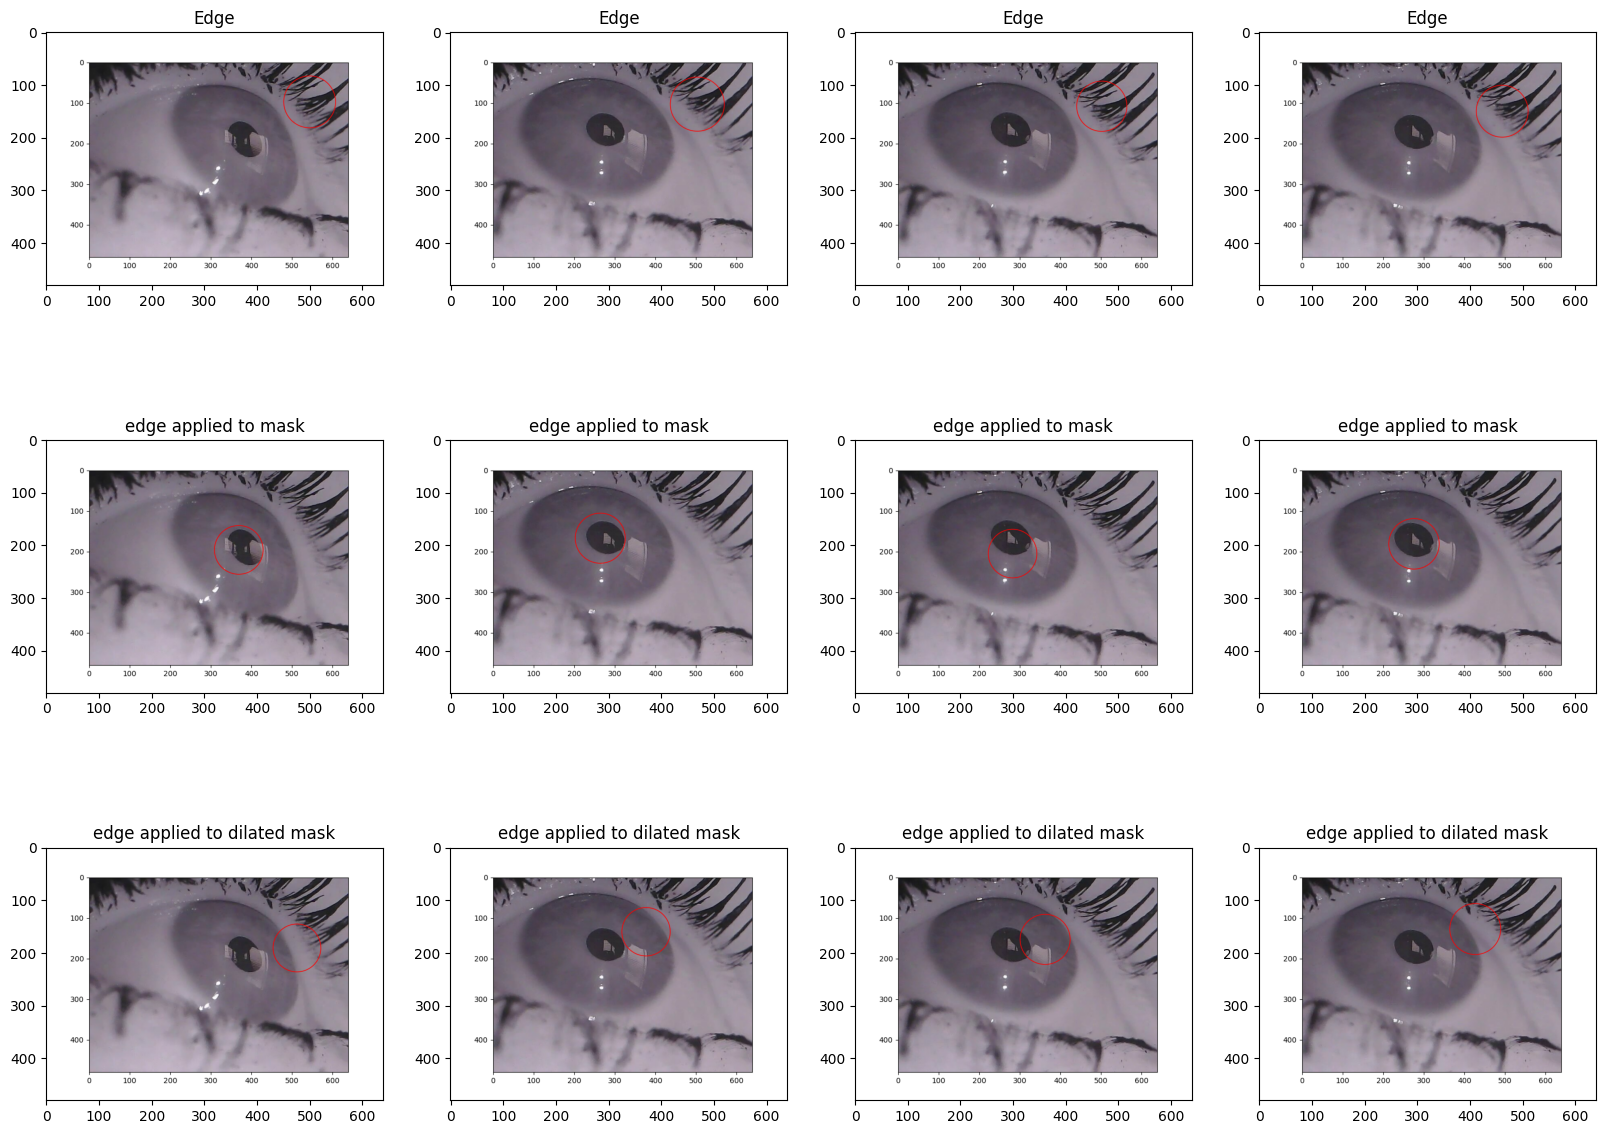

In [25]:
coor_edge = []
coor_edge_mask = []
coor_edge_dilated_mask = []
disp_edge = []
disp_edge_mask = []
disp_edge_dilated_mask = []

fig, axes = plt.subplots(figsize=(20, 15), ncols=4, nrows=3)
for i in tqdm(range(4)):
    coor_edge.append(detectCircles(edge[i],10,15,radius=[80,15]))
    coor_edge_mask.append(detectCircles(mask_edge[i],10,15,radius=[80,15]))
    coor_edge_dilated_mask.append(detectCircles(dilated_mask_edge[i],10,15,radius=[80,15]))

    disp_edge.append(NewdisplayCircles(image[i], coor_edge[i], "edge_circle_{}.png".format(i)))
    disp_edge_mask.append(NewdisplayCircles(image[i], coor_edge_mask[i], "edge_mask_circle_{}.png".format(i)))
    disp_edge_dilated_mask.append(NewdisplayCircles(image[i], coor_edge_dilated_mask[i], "edge_dilated_mask_circle_{}.png".format(i)))


    axes[0][i].set_title("Edge")
    axes[0][i].imshow(disp_edge[i])
    axes[1][i].set_title("edge applied to mask")
    axes[1][i].imshow(disp_edge_mask[i])
    axes[2][i].set_title("edge applied to dilated mask")
    axes[2][i].imshow(disp_edge_dilated_mask[i])

100%|██████████| 4/4 [00:11<00:00,  2.80s/it]


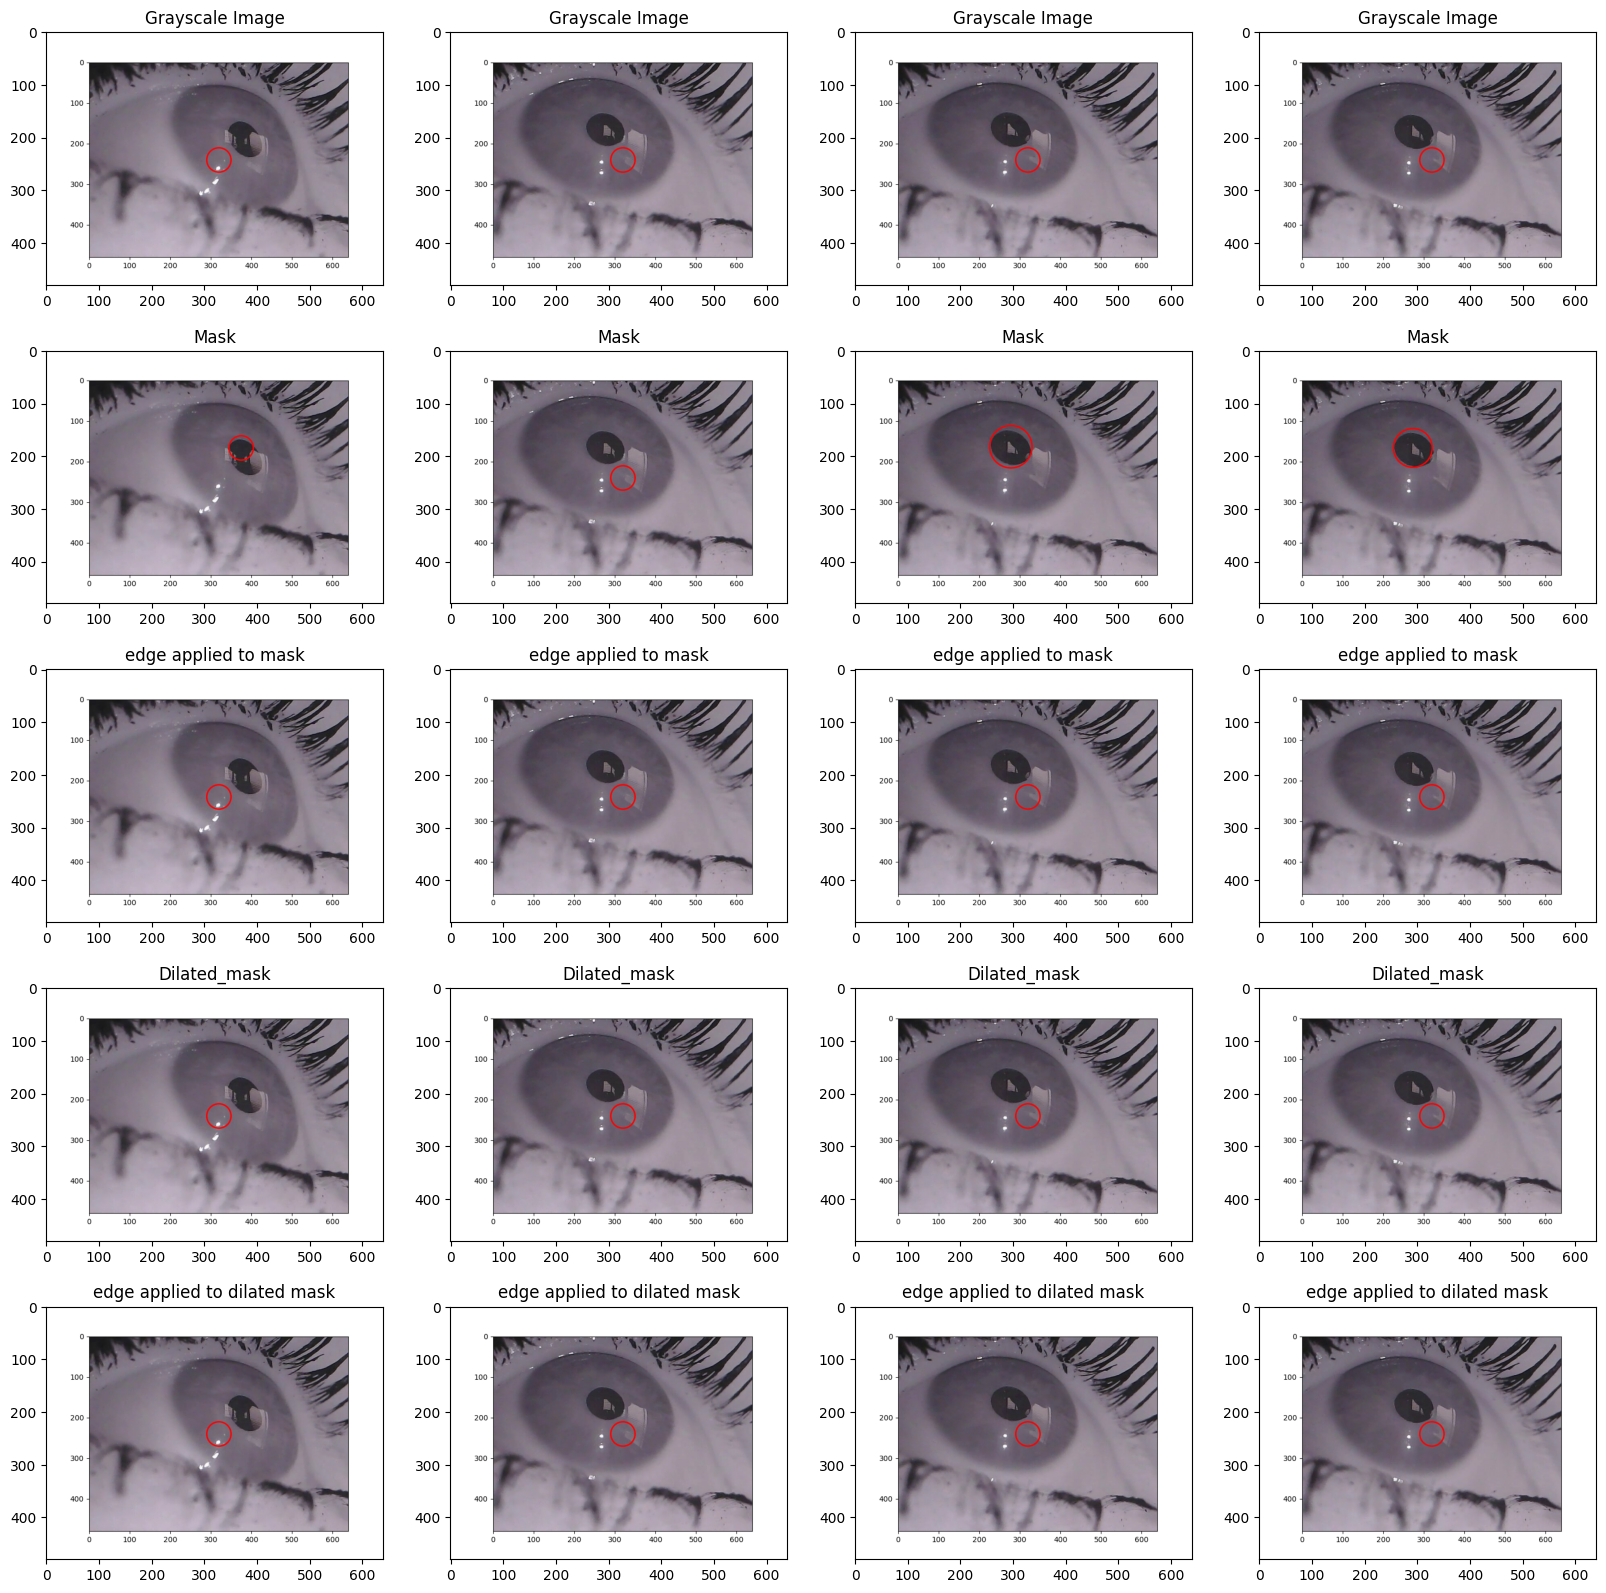

In [26]:
gray_blob = []
edge_blob = []
mask_blob = []
mask_edge_blob = []
dilated_mask_blob = []
dilated_mask_edge_blob = []

disp_gray_blob = []
disp_edge_blob = []
disp_mask_blob = []
disp_mask_edge_blob = []
disp_dilated_mask_blob = []
disp_dilated_mask_edge_blob = []

fig, axes = plt.subplots(figsize=(20, 20), ncols=4, nrows=5)
for i in tqdm(range(4)):
    
    gray_blob.append(blob_doh(gray[i], max_sigma=70, min_sigma=30, threshold=.05))
    mask_blob.append(blob_doh(mask[i], max_sigma=70, min_sigma=30, threshold=.05))
    mask_edge_blob.append(blob_doh(mask_edge[i], max_sigma=70, min_sigma=30, threshold=.05))
    dilated_mask_blob.append(blob_doh(dilated_mask[i], max_sigma=70, min_sigma=30, threshold=.05))
    dilated_mask_edge_blob.append(blob_doh(dilated_mask_edge[i], max_sigma=70, min_sigma=30, threshold=.05))

    disp_gray_blob.append(displayBlob(image[i], gray_blob[i], "gray_blob_{}.png".format(i)))
    disp_mask_blob.append(displayBlob(image[i], mask_blob[i], "gray_blob_{}.png".format(i)))
    disp_mask_edge_blob.append(displayBlob(image[i], mask_edge_blob[i], "gray_blob_{}.png".format(i)))
    disp_dilated_mask_blob.append(displayBlob(image[i], dilated_mask_blob[i], "gray_blob_{}.png".format(i)))
    disp_dilated_mask_edge_blob.append(displayBlob(image[i], dilated_mask_edge_blob[i], "gray_blob_{}.png".format(i)))

    axes[0][i].imshow(disp_gray_blob[i], cmap='gray')
    axes[0][i].set_title("Grayscale Image")
    axes[1][i].imshow(disp_mask_blob[i], cmap='gray')
    axes[1][i].set_title("Mask")
    axes[2][i].imshow(disp_mask_edge_blob[i], cmap='gray')
    axes[2][i].set_title("edge applied to mask")
    axes[3][i].imshow(disp_dilated_mask_blob[i], cmap='gray')
    axes[3][i].set_title("Dilated_mask")
    axes[4][i].imshow(disp_dilated_mask_edge_blob[i], cmap='gray')
    axes[4][i].set_title("edge applied to dilated mask")

In [27]:
image_path = '1_000/'
files = os.listdir(image_path)
num_files = len(files)

In [28]:
image = []
gray = []
list_of_names = []
for i in files:
    list_of_names.append(i)
list_of_names.sort()
for i in range(len(list_of_names)):
    image.append(imread(image_path+list_of_names[i]))
    gray.append(rgb2gray(image[i]))
print(len(image))
print(len(gray))

212
212


In [53]:
mask = []
mask_blob = []
dilated_mask = []
dilated_mask_edge = []
my_dilated_mask_edge = []
my_coor_edge_dilated_mask = []
coor_edge_dilated_mask = []
disp_mask_blob = []
disp_edge_dilated_mask = []
my_disp_edge_dilated_mask = []
coor_blob = []
coor_circles = []
my_coor_circles = []

for i in tqdm(range(len(gray))):
    mask.append(mask_image(gray[i],0.2))
    dilated_mask.append(dilated_image(mask[i], 5))

    # my_dilated_mask_edge.append(canny_edge_detector(dilated_mask[i]).astype(np.uint8))
    # my_coor_edge_dilated_mask.append(detectCircles(my_dilated_mask_edge[i],10,15,radius=[80,15]))
    # # my_disp_edge_dilated_mask.append(NewdisplayCircles(image[i], my_coor_edge_dilated_mask[i], "my_circle_estimation/my_edge_dilated_mask_circle_{}.png".format(i)))
    # my_coor_circles.append(output_coor_circles(image[i], my_coor_edge_dilated_mask[i]))

    dilated_mask_edge.append(canny(dilated_mask[i], sigma=3, low_threshold=0.2, high_threshold=0.4).astype(np.uint8))
    coor_edge_dilated_mask.append(hough_circle(dilated_mask_edge[i], np.arange(15, 80)))
    # disp_edge_dilated_mask.append(NewdisplayCircles(image[i], coor_edge_dilated_mask[i], "circle_estimation/edge_dilated_mask_circle_{}.png".format(i)))
    coor_circles.append(output_coor_circles(image[i], coor_edge_dilated_mask[i]))

    mask_blob.append(blob_doh(mask[i], max_sigma=75, min_sigma=36, threshold=.05))
    # disp_mask_blob.append(displayBlob(image[i], mask_blob[i], "blob_estimation/mask_blob_{}.png".format(i)))
    coor_blob.append(output_coor_blob_safe(image[i], mask_blob[i],coor_circles[i]))
    # coor_blob.append(output_coor_blob(image[i], mask_blob[i]))


100%|██████████| 212/212 [02:32<00:00,  1.39it/s]


In [54]:
# column_names = ['predicted_r','predicted_y','predicted_x']
# df_my_coor_circles = pd.DataFrame(my_coor_circles, columns=column_names)
# df_my_coor_circles = df_my_coor_circles[['predicted_y','predicted_x']]
# print(df_my_coor_circles.head())
# print(df_my_coor_circles.shape)

In [55]:
column_names = ['predicted_r','predicted_y','predicted_x']
df_coor_circles = pd.DataFrame(coor_circles, columns=column_names)
df_coor_circles = df_coor_circles[['predicted_y','predicted_x']]
print(df_coor_circles.head())
print(df_coor_circles.shape)

   predicted_y  predicted_x
0   306.220815   331.816091
1   305.124420   332.026265
2   304.388529   331.025398
3   302.750132   329.383669
4   300.403364   327.562659
(212, 2)


In [56]:
column_names=['predicted_y','predicted_x','predicted_r']
df_coor_blob = pd.DataFrame(coor_blob, columns=column_names)
df_coor_blob = df_coor_blob[['predicted_y','predicted_x']]
print(df_coor_blob.head())
print(df_coor_blob.shape)


   predicted_y  predicted_x
0        305.0        330.0
1        304.0        330.0
2        304.0        329.0
3        303.0        328.0
4        300.0        326.0
(212, 2)


In [57]:
columns_to_mean = ['predicted_y','predicted_x']
df_coor_mean = (df_coor_circles[columns_to_mean].add(df_coor_blob[columns_to_mean]))/2
print(df_coor_mean.shape)
print(df_coor_mean.head())


(212, 2)
   predicted_y  predicted_x
0   305.610407   330.908045
1   304.562210   331.013133
2   304.194264   330.012699
3   302.875066   328.691834
4   300.201682   326.781330


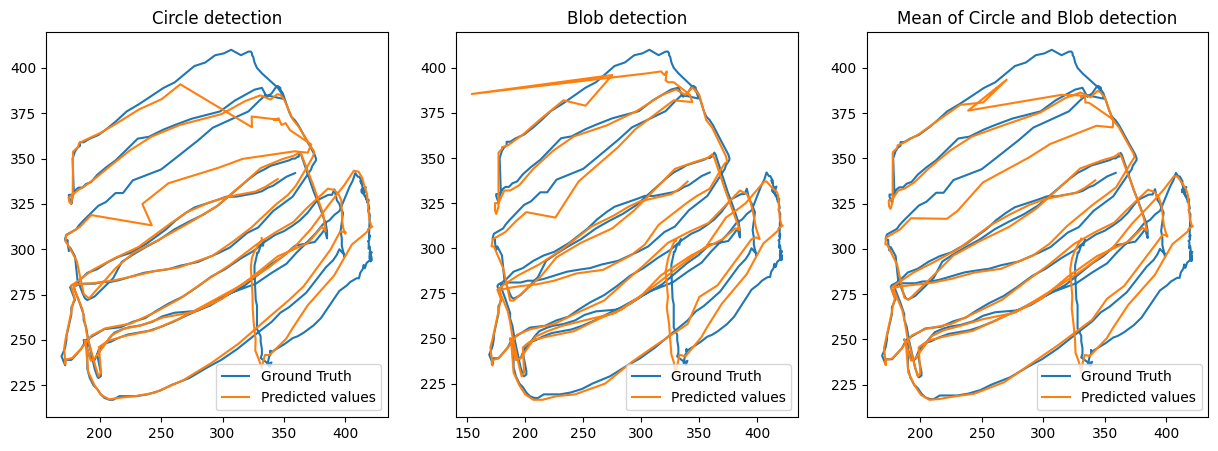

In [71]:
# Create a new figure
fig, ax = plt.subplots(figsize=(15, 5), ncols=3)

# ax[1].plot(df['x'], df['y'])
# ax[1].plot(df_my_coor_circles['predicted_x'],df_my_coor_circles['predicted_y'])


ax[0].plot(df['x'], df['y'], label='Ground Truth')
ax[0].plot(df_coor_circles['predicted_x'],df_coor_circles['predicted_y'], label='Predicted values')
ax[0].legend()
ax[0].set_title("Circle detection")

ax[1].plot(df['x'], df['y'], label='Ground Truth')
ax[1].plot(df_coor_blob['predicted_x'],df_coor_blob['predicted_y'], label='Predicted values')
ax[1].legend()
ax[1].set_title("Blob detection")

ax[2].plot(df['x'], df['y'], label='Ground Truth')
ax[2].plot(df_coor_mean['predicted_x'],df_coor_mean['predicted_y'], label='Predicted values')
ax[2].legend()
ax[2].set_title("Mean of Circle and Blob detection")

# Show the plot
plt.show()

In [ ]:
# fig, axes = plt.subplots(figsize=(50, 500), nrows=43, ncols=5,)
# axes = axes.ravel()
# # iterate through the images and display them
# for i in range(len(disp_mask_blob)):
#     axes[i].imshow(disp_mask_blob[i], cmap='gray')
#     axes[i].axis('off')

# plt.show()

In [ ]:
# fig, axes = plt.subplots(figsize=(50, 500), nrows=43, ncols=5,)
# axes = axes.ravel()
# # iterate through the images and display them
# for i in range(len(disp_edge_dilated_mask)):
#     axes[i].imshow(disp_edge_dilated_mask[i], cmap='gray')
#     axes[i].axis('off')

# plt.show()

In [ ]:
ratio = len(df)/len(df_coor_mean)
print(ratio)
# Create a new DataFrame 'new_df' that includes every 9th row of 'df'
true_df = df.iloc[0::round(ratio), :]
print(true_df.head())
print(true_df.shape)

9.433962264150944
        y      x
0   305.0  334.0
9   302.2  333.0
18  302.0  331.4
27  299.2  329.6
36  297.8  328.0
(223, 2)


In [ ]:
rows = []
for i in range(212):
    index = round(i*ratio)
    row = df.iloc[index]
    new_row = pd.DataFrame(row).T
    rows.append(new_row)

reshape_df = pd.concat(rows)

print(reshape_df.head())


        y      x
0   305.0  334.0
9   302.2  333.0
19  302.0  331.2
28  298.8  329.4
38  297.4  328.0


In [ ]:
from sklearn.metrics import mean_absolute_error
from sklearn.metrics import mean_squared_error
from math import sqrt
from sklearn.metrics import r2_score
from sklearn.metrics import explained_variance_score

def metric(y_true, y_pred):
    mae = mean_absolute_error(y_true, y_pred)
    mse = mean_squared_error(y_true, y_pred)
    rmse = sqrt(mse)
    r2 = r2_score(y_true, y_pred)
    evs = explained_variance_score(y_true, y_pred)
    metrics=[mae,mse,rmse,r2,evs]
    return metrics

    

In [ ]:
metric(reshape_df, df_my_coor_circles)

ValueError: Found input variables with inconsistent numbers of samples: [212, 0]

In [ ]:
metric(reshape_df, df_coor_circles)

[5.7715361264698615,
 92.72378995967229,
 9.629319288489311,
 0.9725194595163309,
 0.9727630559560254]

In [ ]:
metric(reshape_df, df_coor_blob)

[5.009093965066034,
 93.14906364303604,
 9.651376256422504,
 0.9798268600453482,
 0.980061933542204]

In [ ]:
metric(reshape_df, df_coor_mean)

[5.112364500765787,
 64.59968059882601,
 8.037392649287828,
 0.9820838175432096,
 0.9821209128563377]